## Import necessary python libraries

In [1]:
import feyn
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
import warnings
warnings.filterwarnings('ignore')
import collections
import os

In [68]:
from functions import *

In [3]:
feyn.__version__

'2.1.2'

In [42]:
projectname = 'insulin_response_'
pathname = '../figures/'

## Load necessary files

In [38]:
expression_table = '../data/insulin_dataset.csv'
data_togo = pd.read_csv(expression_table, sep=',')

In [5]:
data_togo.head()

,Cond,7SK,A1BG,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZYX,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-3180-3,hsa-mir-3180-4,hsa-mir-6080,hsa-mir-8072,Class_,CV_Split
0,NG1f0,61.707,0.869,22.325312,5.504,1.3035,26.7975,6.373,77.641,1.3035,...,14.70225,27.232,11.0085,1.5930,1.4490,0.869,1.738,2.028,0.0,0.0
1,NG1h0,67.008,1.600,29.549125,4.621,2.7550,22.2175,43.013,57.232,3.7325,...,17.32925,29.149,13.0635,2.0440,2.0440,0.711,0.889,2.488,1.0,0.0
2,NG2f0,37.882,3.164,20.439625,7.035,23.3330,28.9115,19.316,51.453,1.7900,...,41.75375,57.489,10.6155,6.6395,11.3650,7.576,1.499,1.957,0.0,1.0
3,NG2h0,75.477,2.901,16.411500,6.017,24.4965,30.2445,20.091,62.101,1.4775,...,25.87975,58.394,11.2005,5.6140,8.5955,4.029,1.558,1.826,1.0,1.0
4,NG3f0,131.061,8.107,13.412812,16.214,43.6870,28.3740,3.828,0.000,1.0135,...,60.01325,47.515,4.5040,6.3055,3.7155,1.126,0.901,3.828,0.0,2.0


In [6]:
# make dictionary to store original features names
features_dict = dict()
for genes_names in data_togo.columns:
    qlattice_gene_names = genes_names.replace(".", "_").replace(".", "_")
    features_dict[qlattice_gene_names] = genes_names

## Standardise feature names

In [224]:
data_togo.columns = data_togo.columns.str.replace(".", "_")
data_togo.columns = data_togo.columns.str.replace("-", "_")

## Training a QLattice in a cross-validation scheme as framework


In [9]:
logdir='../models_insulin_paper/'
os.makedirs(logdir, exist_ok=True)


partitions_interval = np.arange(5)
inner_partitions_interval = partitions_interval#[partitions_interval != 4]

results = ModelResults()

all_fold_models = []


for val_partition in inner_partitions_interval:
    os.makedirs('%spartition_%i' % (logdir, val_partition), exist_ok=True)
    model_file = "%spartition_%i/model" % (logdir, val_partition)
    train = data_togo.loc[(data_togo.CV_Split != val_partition)]
    val = data_togo.loc[(data_togo.CV_Split == val_partition)]
    
    # Connecting to the QLattice
    
    ql = feyn.connect_qlattice()

    # Setting a seed
    
    ql.reset(random_seed=42)  

    stypes = dict()
    for f in train.columns:
        if train[f].dtype =='object':
            stypes[f] = 'c'
            
    models_ = ql.auto_run(data=train,
                          output_name="Class_",
                          kind="classification",
                          n_epochs=50,
                          max_complexity=5,
                          stypes=stypes,
                          criterion="bic",
                 )
    
    all_fold_models.append(models_)
    
    for j in models_:
        results.update(train, val, val_partition, j)
    
    for i in range(len(models_)):    
        models_[i].save(model_file+'_'+str(val_partition)+'_'+str(i)+'.json')
        
    

In [67]:
np.mean(results.df.groupby("fold").first().roc_auc_val), np.mean(results.df.roc_auc_val)

(0.9397024245595673, 0.9511417971527862)

In [400]:
np.std(results.df.groupby("fold").first().roc_auc_val), np.std(results.df.roc_auc_val)

(0.03765627803312279, 0.04075683216571719)

In [401]:
feat_list = list()
for j in np.arange(5):
    for i in range(len(all_fold_models[j])):
        genes = all_fold_models[j][i].features
        for gene in genes:
            if gene in features_dict.keys():
                feat_list.append(features_dict[gene])
            
count_features = collections.Counter(feat_list)
count_features_df = pd.DataFrame(count_features.items(),columns=['Gene', 'Count']).sort_values('Count', ascending=False)

### Compare with differential gene expression

In [402]:
de = pd.read_csv("../data/obesity_delist.csv")
de = de[de["FDR"]<0.05].sort_values(by="FDR")
de["de_position"] = np.arange(len(de))

In [403]:
compare_df = pd.merge(count_features_df.reset_index(drop=True), 
                      de[['gene', 'de_position', 'FDR']].groupby(['gene']).first(), 
                      left_on='Gene', right_on='gene', how="left")

In [406]:
compare_df.head(20)

,Gene,Count,de_position,FDR
0,PHF23,14,260.0,0.001108
1,CDKN1A,13,75.0,0.000012
2,SPRY4,9,33.0,0.000002
3,CBX4,8,652.0,0.034501
4,HEXIM1,5,253.0,0.000950
5,PDK4,4,64.0,0.000008
6,PPARGC1B,3,345.0,0.004460
7,RASD1,3,432.0,0.010535
8,CATG00000000907.1,2,269.0,0.001421
9,CTGF,2,95.0,0.000025


## Training a QLattice in train-test split mode for final model choice



In [342]:
logdir='../models_insulin_paper_train_test/'
os.makedirs(logdir, exist_ok=True)

results_train_test = ModelResults()
os.makedirs('%spartition_%i' % (logdir, 1), exist_ok=True)
model_file = "%spartition_%i/model" % (logdir, 1)
train = data_togo.loc[(data_togo.CV_Split != 1)]
test = data_togo.loc[(data_togo.CV_Split == 1)]

# Connecting to the QLattice

ql = feyn.connect_qlattice()

# Setting a seed

ql.reset(random_seed=42)  

stypes = dict()
for f in train.columns:
    if train[f].dtype =='object':
        stypes[f] = 'c'

models_ = ql.auto_run(data=train,
                      output_name="Class_",
                      kind="classification",
                      n_epochs=50,
                      max_complexity=5,
                      stypes=stypes,
                      criterion="bic",
             )

#for j in models_:
#    results_train_test.update(train, test, 1, j)

#for i in range(len(models_)):    
#    models_[i].save(model_file+'_'+str(1)+'_'+str(i)+'.json')

In [343]:
df_summary = modsum(models_, train, test)[['N. Features', 'Functional form', 'BIC', 'Loss', 'AUC Train']]
df_summary

,N. Features,Functional form,BIC,Loss,AUC Train
0,3,logreg(PHF23 + PPP1R35 + RNU6ATAC),19.58,0.045276,1.0
1,3,logreg(C2CD2L + PDK4 + PHF23),20.79,0.050682,1.0
2,3,logreg(CATG000000438721*CDADC1 + SPRY4),20.81,0.029703,1.0
3,3,logreg(AC0271191 + CATG000000327481 + PHF23),28.02,0.082960,1.0
4,3,logreg(CATG000000004671 + MARCH8 + PHF23),34.91,0.113712,0.99
5,2,logreg(SPRY4 + 1/EEF2K),36.47,0.120684,0.99
6,3,logreg(ERVK131 + PHF23 + SPRY4),36.51,0.120844,0.99
7,3,logreg(C19orf80 + CEBPD + DDX6),37.29,0.124340,0.99
8,3,logreg(CBX4 + ESAM + LDLR),38.09,0.127931,0.99
9,3,logreg(CDKN1A + CTB55O610 + ID2),38.27,0.128724,0.99


In [72]:
print(df_summary.to_latex())

\begin{tabular}{lrllrl}
\toprule
{} &  N. Features &                                 Functional form &    BIC &      Loss & AUC Train \\
\midrule
0 &            3 &              logreg(PHF23 + PPP1R35 + RNU6ATAC) &  19.58 &  0.045276 &       1.0 \\
1 &            3 &                   logreg(C2CD2L + PDK4 + PHF23) &  20.79 &  0.050682 &       1.0 \\
2 &            3 &        logreg(CATG00000043872.1*CDADC1 + SPRY4) &  20.81 &  0.029703 &       1.0 \\
3 &            3 &  logreg(AC027119.1 + CATG00000032748.1 + PHF23) &  28.02 &  0.082960 &       1.0 \\
4 &            3 &      logreg(CATG00000000467.1 + MARCH8 + PHF23) &  34.91 &  0.113712 &      0.99 \\
5 &            2 &                         logreg(SPRY4 + 1/EEF2K) &  36.47 &  0.120684 &      0.99 \\
6 &            3 &                logreg(ERVK13-1 + PHF23 + SPRY4) &  36.51 &  0.120844 &      0.99 \\
7 &            3 &                 logreg(C19orf80 + CEBPD + DDX6) &  37.29 &  0.124340 &      0.99 \\
8 &            3 &            

In [73]:
model = models_[1]

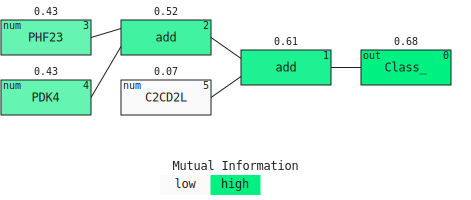

In [74]:
model.plot_signal(train, corr_func='mutual_information', 
                             filename=pathname+projectname+'plot_signal_mi.svg')

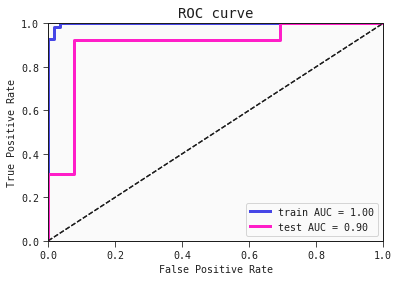

In [75]:
model.plot_roc_curve(train, label='train')
model.plot_roc_curve(test, label='test', ax=plt.gca())
plt.savefig(pathname+projectname+'roc_auc'+'.pdf', dpi=300, bbox_inches='tight')

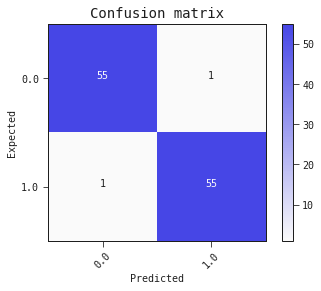

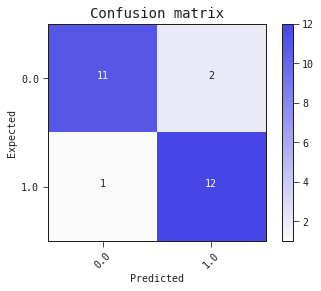

In [76]:
model.plot_confusion_matrix(train, filename=pathname+projectname+'confusion_train'+'.pdf')
model.plot_confusion_matrix(test, filename=pathname+projectname+'confusion_test'+'.pdf')

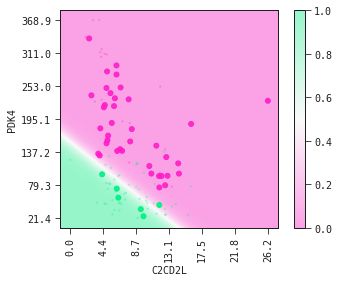

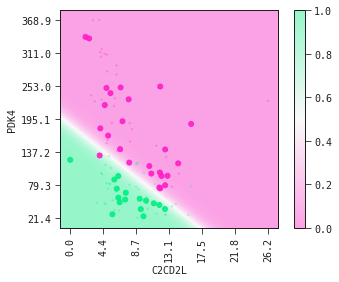

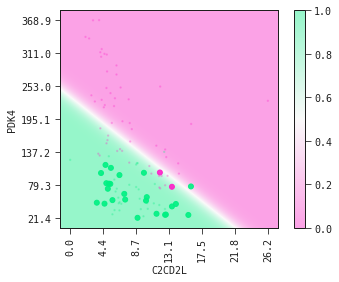

In [397]:
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"PHF23":train.PHF23.quantile(0.25)})
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"PHF23":train.PHF23.quantile(0.50)})
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"PHF23":train.PHF23.quantile(0.75)})

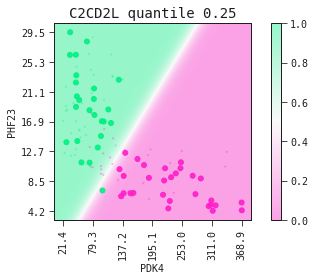

In [418]:
model.plot_response_2d(train[model.inputs + ['Class_']],fixed={"C2CD2L":train.C2CD2L.quantile(0.25)})
plt.title(label="C2CD2L quantile 0.25")
plt.tight_layout()
plt.savefig(pathname+projectname+"response2d_25.pdf", bbox_inches='tight')

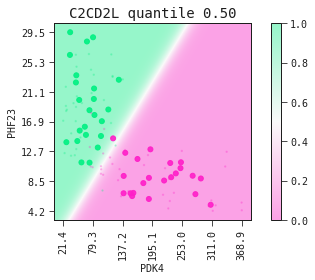

In [419]:
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"C2CD2L":train.C2CD2L.quantile(0.50)})
plt.title(label="C2CD2L quantile 0.50")
plt.tight_layout()
plt.savefig(pathname+projectname+"response2d_50.pdf")

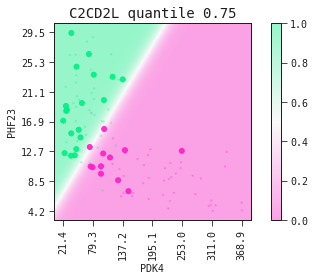

In [420]:
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"C2CD2L":train.C2CD2L.quantile(0.75)})
plt.title(label="C2CD2L quantile 0.75")
plt.tight_layout()
plt.savefig(pathname+projectname+"response2d_75.pdf")

In [380]:
train.C2CD2L.quantile(0.25)

4.9285

<AxesSubplot:>

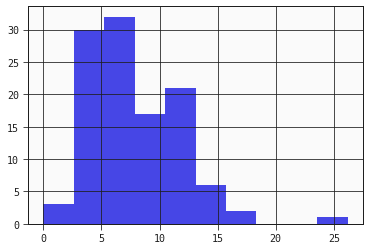

In [379]:
train.C2CD2L.hist()

In [375]:
print(model.sympify())

logreg(-1.09552*C2CD2L - 0.104333*PDK4 + 0.868373*PHF23 + 8.21244)


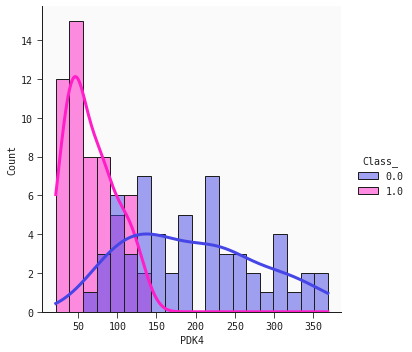

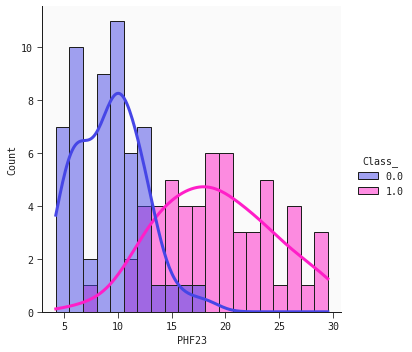

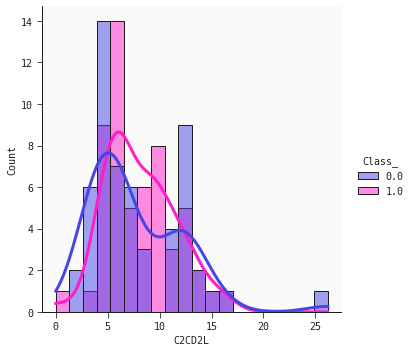

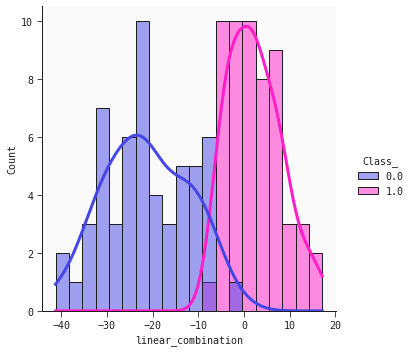

In [395]:
#sns.displot(-0.104333*train[train['Class_']==0]['PDK4'] + 0.868373*train[train['Class_']==0]['PHF23'], kde=True)
sns.displot(train[["PDK4", "Class_"]],x="PDK4", hue="Class_", kde=True, bins=20,)
plt.savefig(pathname+projectname+"distPDK4.pdf")
sns.displot(train[["PHF23", "Class_"]],x="PHF23", hue="Class_", kde=True, bins=20)
plt.savefig(pathname+projectname+"distPHF23.pdf")
sns.displot(train[["C2CD2L", "Class_"]],x="C2CD2L", hue="Class_", kde=True, bins=20)
plt.savefig(pathname+projectname+"distC2CD2L.pdf")
sns.displot(train[["linear_combination", "Class_"]],x="linear_combination", hue="Class_", kde=True, bins=20)
plt.savefig(pathname+projectname+"distLC.pdf")

In [376]:
train['linear_combination'] = -0.104333*train['PDK4'] + 0.868373*train['PHF23'] -1.09552*train['C2CD2']

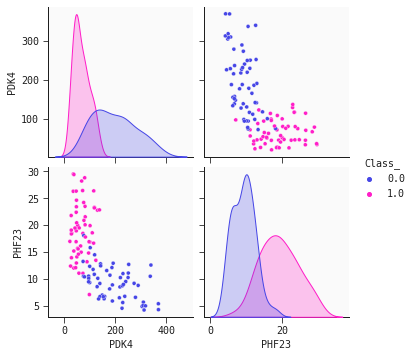

In [344]:
sns.pairplot(train[list(['PDK4', 'PHF23']) + ['Class_']], hue = 'Class_')